In [12]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [5]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g

CPython 3.6.4
IPython 6.2.1

numpy 1.14.0
scipy 1.0.0
pandas 0.22.0
matplotlib 2.1.2
sklearn 0.19.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : f153536d4a2bbc9582b8f5e96fcd054b84713427


In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from tqdm import tqdm_notebook
import pandas as pd
from collections import defaultdict

# поменяйте на свой путь
DS_FILE_NAME = '../data/stackoverflow_sample_125k.tsv'
TAGS_FILE_NAME = '../data/top10_tags.tsv'

In [13]:
top_tags = []
with open(TAGS_FILE_NAME, 'r') as f:
    for line in f:
        top_tags.append(line.strip())
top_tags = set(top_tags)
print(top_tags)

{'python', 'c#', 'jquery', 'c++', 'ios', 'android', 'html', 'java', 'php', 'javascript'}


In [17]:
class LogRegressor():
    
    """Конструктор
    
    Параметры
    ----------
    tags_top : list of string, default=tags_top
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16):
        
        self._loss = []
        n = 0
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                
                # значение функции потерь для текущего примера
                sample_loss = 0

                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # z = ...
                    z = self._b[tag] 
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        # z += ...
                        z += self._w[tag][self._vocab[word]] 
                        
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sigma = ...
                    sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
                    
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sample_loss += ...
                    sample_loss += -y*np.log(np.max([tolerance, sigma])) if y == 1 else \
                                   -(1 - y)*np.log(1 - np.min([1 - tolerance, sigma]))
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        # dLdw = ...
                        dLdw = y - sigma

                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:                        
                            self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        self._b[tag] -= -learning_rate*dLdw
                    
                n += 1
                        
                self._loss.append(sample_loss)
            

In [18]:
%%time
model = LogRegressor()
model.iterate_file()

HBox(children=(IntProgress(value=0, max=125000), HTML(value='')))


CPU times: user 4min 51s, sys: 4.35 s, total: 4min 55s
Wall time: 5min


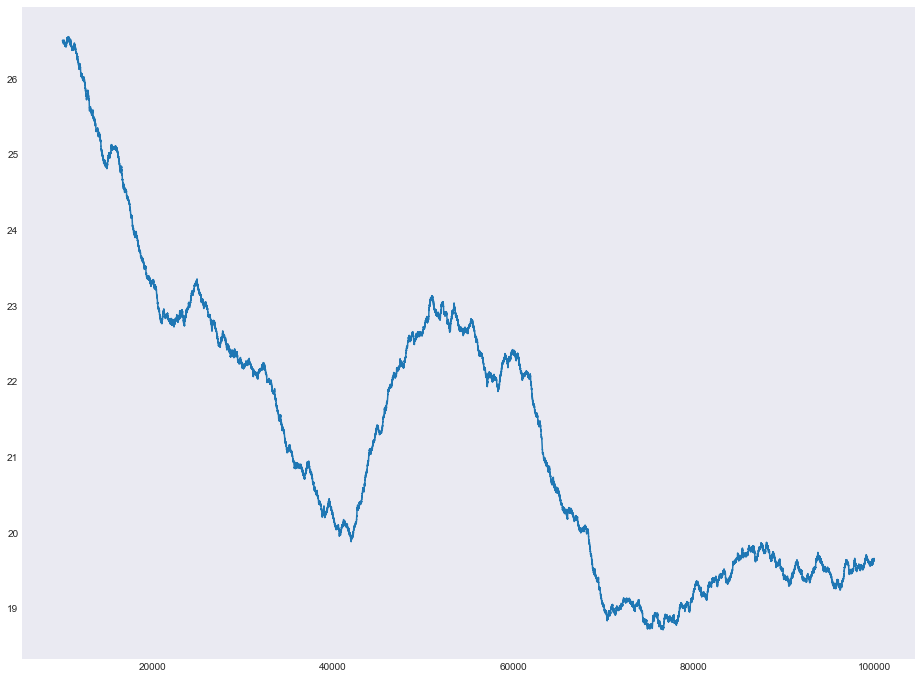

In [22]:
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

In [26]:
model._vocab_inv = dict([(v, k) for (k, v) in model._vocab.items()])

for tag in model._tags:
    print(tag, ':', ', '.join([model._vocab_inv[k] for (k, v) in 
                               sorted(model._w[tag].items(), 
                                      key=lambda t: t[1], 
                                      reverse=True)[:5]]))    

python : python, def, 00, py, django
c# : xsl, writeline, binding, net, linq
jquery : jquery, ajax, ready, val, span
c++ : avrf, c++, std, cout, boost
ios : ios, dylib, nsstring, uiview, nil
android : android, activity, arm, androideabi, quot
html : 3, html, br, amp, nav
java : println, java, hibernate, spring, servlet
php : php, _post, echo, x5c, 125
javascript : javascript, x20, 125, x30, x44


In [27]:
class LogRegressor():
    
    def __init__(self, tags=top_tags):      
        self._vocab = {}
        self._w = dict([(t, defaultdict(int)) for t in tags])
        self._b = dict([(t, 0) for t in tags])
        self._tags = set(tags)
        self._word_stats = defaultdict(int)
    
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16,
                     accuracy_level=0.9,
                     lmbda=0.0002,
                     gamma=0.1,
                     update_vocab=True):

        self._loss = []
        n = 0
        accuracy = []
        with open(fname, 'r') as f:            
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                sentence = sentence.split(' ')
                tags = set(tags.split(' '))
                
                sample_loss = 0
                predicted_tags = None
                
                for tag in self._tags:
                    y = int(tag in tags)
                    
                    z = self._b[tag] 
                    for word in sentence:
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab and update_vocab:
                            self._vocab[word] = len(self._vocab)
                        if word not in self._vocab:
                            continue
                        if update_vocab:
                            self._word_stats[self._vocab[word]] += 1
                        z += self._w[tag][self._vocab[word]] 
                        
                    sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
                    
                    sample_loss += -y*np.log(np.max([tolerance, sigma])) if y == 1 else \
                                   -(1 - y)*np.log(1 - np.min([1 - tolerance, sigma]))
                    
                    if n < top_n_train:
                        dLdw = y - sigma

                        for word in sentence:  
                            if word not in self._vocab:
                                continue
                            self._w[tag][self._vocab[word]] -= -learning_rate * dLdw \
                                + 2 * learning_rate * lmbda * gamma * self._w[tag][self._vocab[word]] \
                                + learning_rate * lmbda *(1 - gamma) * np.sign(self._w[tag][self._vocab[word]])
                        self._b[tag] -= -learning_rate * dLdw
                    else:
                        if predicted_tags is None:
                            predicted_tags = []
                        if sigma > accuracy_level:
                            predicted_tags.append(tag)
                    
                n += 1
                                        
                self._loss.append(sample_loss)
                if predicted_tags is not None:
                    accuracy.append(len(tags.intersection(predicted_tags))/len(tags.union(predicted_tags)))
            
        return(np.mean(accuracy))
    
    def filter_vocab(self, n=10000):
        keep_words = set([wid for (wid, wn) in sorted(self._word_stats.items(), 
                                                      key=lambda t: t[1], reverse=True)[:n]])
        self._vocab = dict([(k, v) for (k, v) in self._vocab.items() if v in keep_words])
        for tag in self._tags:
            self._w[tag] = dict([(k, v) for (k, v) in self._w[tag].items() if k in keep_words])
            

HBox(children=(IntProgress(value=0, max=125000), HTML(value='')))


0.59
CPU times: user 16min 38s, sys: 12.5 s, total: 16min 51s
Wall time: 17min 5s


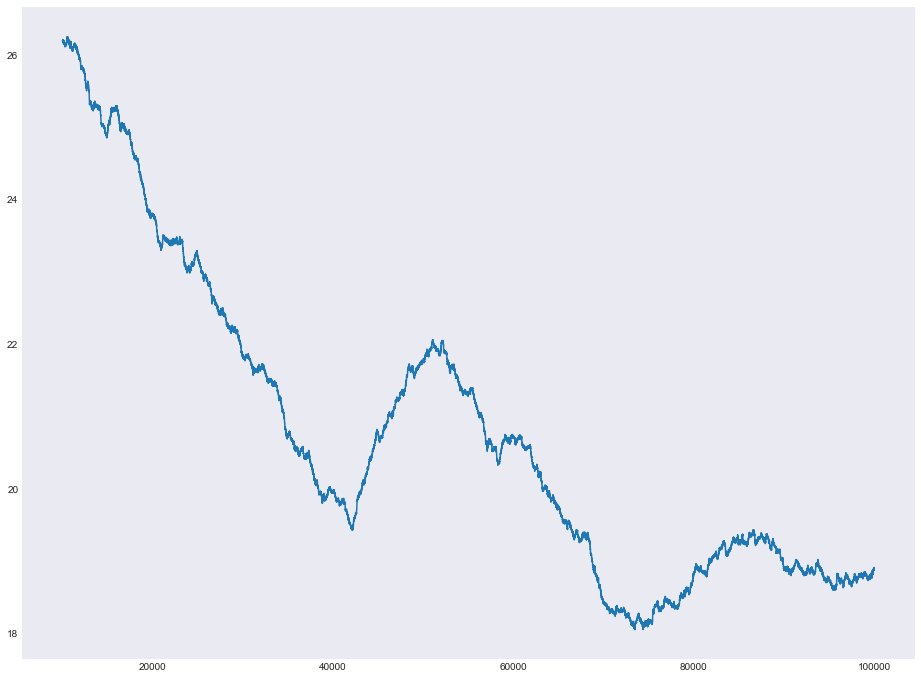

In [28]:
%%time
model = LogRegressor()
acc = model.iterate_file(update_vocab=True)
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

In [ ]:
model.filter_vocab(n=10000)